# Bringing Bronze Age Voices Back to Life: Dataset Overview & Starter Baselines
This notebook provides a detailed overview of the competition, the dataset, 
and working baseline implementations to help you get started!

Competition Overview:
- Goal: Translate 4,000-year-old Old Assyrian business records from Akkadian to English
- Metric: Geometric mean of BLEU and chrF++ scores

## IMPORTS AND SETUP

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Translation and NLP libraries
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM,
    MarianMTModel,
    MarianTokenizer,
    T5ForConditionalGeneration,
    T5Tokenizer
)
import torch
from tqdm.auto import tqdm

# Evaluation metrics
!pip install sacrebleu
from sacrebleu.metrics import BLEU, CHRF

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2026-01-11 22:38:17.453803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768171097.703043      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768171097.776117      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768171098.379990      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768171098.380036      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768171098.380040      17 computation_placer.cc:177] computation placer alr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.9 MB/s eta 0:00:00
PyTorch version: 2.8.0+cu126
CUDA available: False
/kaggle/input/deep-past-initiative-machine-translation/sample_submission.csv
/kaggle/input/deep-past-initiative-machine-translation/bibliography.csv
/kaggle/input/deep-past-initiative-machine-translation/publications.csv
/kaggle/input/deep-past-initiative-machine-translation/Sentences_Oare_FirstWord_LinNum.csv
/kaggle/input/deep-past-initiative-machine-translation/OA_Lexicon_eBL.csv
/kaggle/input/deep-past-initiative-machine-translation/eBL_Dictionary.csv
/kaggle/input/deep-past-initiative-machine-translation/train.csv
/kaggle/input/deep-past-initiative-machine-translation/test.csv
/kaggle/input/deep-past-initiative-machine-translation/published_texts.csv
/kaggle/input/deep-past-initiative-machine-translation/resources.csv


## BACKGROUND: What is Akkadian?

Akkadian is an ancient Semitic language spoken in Mesopotamia (modern-day Iraq) 
from around 2800 BCE to 100 CE. This competition focuses on Old Assyrian texts
from ~2000-1700 BCE - primarily business records from ancient Kanesh.

Key Challenges:
1. **Cuneiform Complexity**: Polyvalent signs (one sign = multiple meanings)
2. **Limited Data**: Only ~1,500 parallel examples in training set
3. **Fragmentary Texts**: Many tablets are damaged/incomplete
4. **Domain-Specific**: Heavy focus on commercial/administrative language
5. **No Native Speakers**: Language extinct for 2000+ years

Dataset Structure:
- **Training data (~1,500 examples)**: Document-level translations
  - Each row is a complete document/tablet
  - Columns: oare_id, transliteration (Akkadian), translation (English)
  
- **Test data (~4,000 sentences from ~400 documents)**: Sentence-level translations
  - Each row is a single sentence
  - Columns: id, text_id, line_start, line_end, transliteration
  - Multiple sentences per document (text_id groups sentences together)
  
**Important**: Training is document-level, but testing is sentence-level! You may want to split training documents into sentences for better alignment.

Supplemental Data Available:
- **published_texts.csv**: ~8,000 additional transliterations (no translations)
- **publications.csv**: ~880 scholarly PDFs with translations in multiple languages
- **OA_Lexicon_eBL.csv**: Old Assyrian word dictionary
- **eBL_Dictionary.csv**: Complete Akkadian dictionary
- Advanced users can extract and align translations from publications.csv

Prior Research Benchmarks:
- Gutherz et al. (2023): Achieved BLEU4 scores of 36.52 (cuneiform→English) 
  and 37.47 (transliteration→English) on different datasets
- This competition represents a new frontier with Old Assyrian texts

## DATA LOADING AND EXPLORATION

In [2]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/train.csv')
test_df = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/test.csv')
sample_submission = pd.read_csv('/kaggle/input/deep-past-initiative-machine-translation/sample_submission.csv')

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")
print(f"\nFirst few examples:")
print(train_df.head())

# Rename columns for consistency throughout the notebook
# Train: 'transliteration' -> 'source', 'translation' -> 'target'
# Test: 'transliteration' -> 'source'
train_df = train_df.rename(columns={'transliteration': 'source', 'translation': 'target'})
test_df = test_df.rename(columns={'transliteration': 'source'})

print("\n✓ Columns renamed for consistency:")
print(f"  Train: 'transliteration' -> 'source', 'translation' -> 'target'")
print(f"  Test: 'transliteration' -> 'source'")



Train shape: (1561, 3)
Test shape: (4, 5)

Train columns: ['oare_id', 'transliteration', 'translation']
Test columns: ['id', 'text_id', 'line_start', 'line_end', 'transliteration']

First few examples:
                                oare_id  \
0  004a7dbd-57ce-46f8-9691-409be61c676e   
1  0064939c-59b9-4448-a63d-34612af0a1b5   
2  0073f2c0-524c-4bbf-915a-8c1772a4fb98   
3  009fb838-8038-42bc-ad34-5f795b3840ee   
4  00aa1c55-c80c-4346-a159-73ad43ab0ff7   

                                     transliteration  \
0  KIŠIB ma-nu-ba-lúm-a-šur DUMU ṣí-lá-(d)IM KIŠI...   
1               1 TÚG ša qá-tim i-tur₄-DINGIR il₅-qé   
2  TÚG u-la i-dí-na-ku-um i-tù-ra-ma 9 GÍN KÙ.BABBAR   
3  KIŠIB šu-(d)EN.LÍL DUMU šu-ku-bi-im KIŠIB ṣí-l...   
4  um-ma šu-ku-tum-ma a-na IŠTAR-lá-ma-sí ù ni-ta...   

                                         translation  
0  Seal of Mannum-balum-Aššur son of Ṣilli-Adad, ...  
1  Itūr-ilī has received one textile of ordinary ...  
2  ... he did not give you a textile

In [3]:
# Show some example texts
print("\nSample Akkadian-English pairs:")
for i in range(min(3, len(train_df))):
    print(f"\n--- Example {i+1} ---")
    print(f"OARE ID: {train_df.iloc[i]['oare_id']}")
    print(f"Akkadian: {train_df.iloc[i]['source'][:100]}...")
    print(f"English: {train_df.iloc[i]['target'][:100]}...")


Sample Akkadian-English pairs:

--- Example 1 ---
OARE ID: 004a7dbd-57ce-46f8-9691-409be61c676e
Akkadian: KIŠIB ma-nu-ba-lúm-a-šur DUMU ṣí-lá-(d)IM KIŠIB šu-(d)EN.LÍL DUMU ma-nu-ki-a-šur KIŠIB MAN-a-šur DUM...
English: Seal of Mannum-balum-Aššur son of Ṣilli-Adad, seal of Šu-Illil son of Mannum-kī-Aššur, seal of Puzur...

--- Example 2 ---
OARE ID: 0064939c-59b9-4448-a63d-34612af0a1b5
Akkadian: 1 TÚG ša qá-tim i-tur₄-DINGIR il₅-qé...
English: Itūr-ilī has received one textile of ordinary quality....

--- Example 3 ---
OARE ID: 0073f2c0-524c-4bbf-915a-8c1772a4fb98
Akkadian: TÚG u-la i-dí-na-ku-um i-tù-ra-ma 9 GÍN KÙ.BABBAR...
English: ... he did not give you a textile. He returned and 9 shekels of silver ......


## DATA CLEANING AND PREPROCESSING

The competition provides formatting guidelines to clean the transliterations.
This preprocessing can significantly improve model performance by:
1. Removing modern scribal notations
2. Standardizing gaps and breaks
3. Normalizing subscripts and special characters
4. Handling Akkadian determinatives

In [4]:
import re

def clean_transliteration(text):
    """
    Clean Akkadian transliteration according to competition guidelines.
    Removes modern scribal notations and standardizes formatting.
    """
    if pd.isna(text):
        return text
    
    # Remove modern scribal notations
    text = text.replace('!', '')  # certain reading
    text = text.replace('?', '')  # questionable reading
    text = text.replace('/', ' ')  # line divider → space
    text = text.replace(':', ' ')  # word divider → space
    text = text.replace('.', ' ')  # word divider → space
    
    # Remove scribal insertions brackets but keep content
    text = re.sub(r'[<>]', '', text)
    
    # Remove partially broken sign indicators
    text = text.replace('˹', '')
    text = text.replace('˺', '')
    
    # Remove square brackets (restore broken text)
    text = re.sub(r'[\[\]]', '', text)
    
    # Replace gaps with standardized tokens
    text = re.sub(r'\[x\]', '<gap>', text)
    text = re.sub(r'…', '<big_gap>', text)
    text = re.sub(r'\[… …\]', '<big_gap>', text)
    
    # Normalize subscript numbers (e.g., il₅ → il5)
    subscript_map = {
        '₀': '0', '₁': '1', '₂': '2', '₃': '3', '₄': '4',
        '₅': '5', '₆': '6', '₇': '7', '₈': '8', '₉': '9', 'ₓ': 'x'
    }
    for sub, normal in subscript_map.items():
        text = text.replace(sub, normal)
    
    # Normalize special characters to ASCII equivalents
    char_map = {
        'á': 'a2', 'à': 'a3',
        'é': 'e2', 'è': 'e3',
        'í': 'i2', 'ì': 'i3',
        'ú': 'u2', 'ù': 'u3',
        'š': 'sz', 'Š': 'SZ',
        'ṣ': 's,', 'Ṣ': 'S,',
        'ṭ': 't,', 'Ṭ': 'T,',
        'ḫ': 'h', 'Ḫ': 'H',
        'ʾ': "'"
    }
    for special, normal in char_map.items():
        text = text.replace(special, normal)
    
    # Clean up multiple spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

# Apply cleaning to training data
print("Cleaning training data...")
train_df['source_clean'] = train_df['source'].apply(clean_transliteration)

# Show examples of cleaning
print("\nCLEANING EXAMPLES:")
for i in range(min(3, len(train_df))):
    orig = train_df.iloc[i]['source'][:100]
    clean = train_df.iloc[i]['source_clean'][:100]
    if orig != clean:
        print(f"\n--- Example {i+1} ---")
        print(f"Original: {orig}...")
        print(f"Cleaned:  {clean}...")

# Apply cleaning to test data
print("\nCleaning test data...")
test_df['source_clean'] = test_df['source'].apply(clean_transliteration)

# Analyze the impact of cleaning
print("\nCLEANING IMPACT:")
original_chars = len(''.join(train_df['source'].astype(str)))
cleaned_chars = len(''.join(train_df['source_clean'].astype(str)))
print(f"Original total characters: {original_chars:,}")
print(f"Cleaned total characters: {cleaned_chars:,}")
print(f"Reduction: {original_chars - cleaned_chars:,} characters ({(1 - cleaned_chars/original_chars)*100:.1f}%)")

# Count special notation occurrences
notation_counts = {
    'Square brackets []': sum(text.count('[') + text.count(']') for text in train_df['source'].astype(str)),
    'Uncertain readings ?': sum(text.count('?') for text in train_df['source'].astype(str)),
    'Certain readings !': sum(text.count('!') for text in train_df['source'].astype(str)),
    'Angle brackets <>': sum(text.count('<') + text.count('>') for text in train_df['source'].astype(str)),
    'Determinatives {}': sum(text.count('{') for text in train_df['source'].astype(str)),
}

print("\nNOTATION FREQUENCIES IN ORIGINAL DATA:")
for notation, count in sorted(notation_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{notation}: {count:,}")

# From this point forward, we'll use 'source_clean' instead of 'source' for training
print("\n✓ Data cleaning complete! Use 'source_clean' for model training.")

# Bonus: Analyze determinatives
print("\nDETERMINATIVE ANALYSIS:")
print("Determinatives provide semantic context (deity, place, person, etc.)")

determinative_map = {
    '{d}': 'deity',
    '{mul}': 'star/constellation',
    '{ki}': 'place',
    '{lu2}': 'person/profession',
    '{lu₂}': 'person/profession',
    '{e2}': 'building',
    '{e₂}': 'building',
    '{uru}': 'settlement',
    '{kur}': 'land/mountain',
    '{mi}': 'feminine name',
    '{m}': 'masculine name',
    '{gesz}': 'wood/tree',
    '{ĝesz}': 'wood/tree',
    '{tug2}': 'textile',
    '{tug₂}': 'textile',
    '{dub}': 'tablet/document',
    '{id2}': 'river/canal',
    '{id₂}': 'river/canal',
    '{muszen}': 'bird',
    '{mušen}': 'bird',
    '{na4}': 'stone',
    '{kusz}': 'skin/hide',
    '{kuš}': 'skin/hide',
    '{u2}': 'plant',
    '{u₂}': 'plant',
}

det_counts = {}
for det in determinative_map.keys():
    count = sum(text.count(det) for text in train_df['source_clean'].astype(str))
    if count > 0:
        det_counts[det] = count

if det_counts:
    print("\nMost common determinatives:")
    for det, count in sorted(det_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        meaning = determinative_map.get(det, 'unknown')
        print(f"  {det:10s} ({meaning:20s}): {count:4d} occurrences")
    print("\nTip: Determinatives provide valuable semantic context.")
    print("   Consider keeping them or expanding them (e.g., {d} → [deity])")
else:
    print("No determinatives found in this dataset sample.")

Cleaning training data...

CLEANING EXAMPLES:

--- Example 1 ---
Original: KIŠIB ma-nu-ba-lúm-a-šur DUMU ṣí-lá-(d)IM KIŠIB šu-(d)EN.LÍL DUMU ma-nu-ki-a-šur KIŠIB MAN-a-šur DUM...
Cleaned:  KISZIB ma-nu-ba-lu2m-a-szur DUMU s,i2-la2-(d)IM KISZIB szu-(d)EN LÍL DUMU ma-nu-ki-a-szur KISZIB MAN...

--- Example 2 ---
Original: 1 TÚG ša qá-tim i-tur₄-DINGIR il₅-qé...
Cleaned:  1 TÚG sza qa2-tim i-tur4-DINGIR il5-qe2...

--- Example 3 ---
Original: TÚG u-la i-dí-na-ku-um i-tù-ra-ma 9 GÍN KÙ.BABBAR...
Cleaned:  TÚG u-la i-di2-na-ku-um i-tu3-ra-ma 9 GÍN KÙ BABBAR...

Cleaning test data...

CLEANING IMPACT:
Original total characters: 665,703
Cleaned total characters: 743,607
Reduction: -77,904 characters (-11.7%)

NOTATION FREQUENCIES IN ORIGINAL DATA:
Square brackets []: 420
Uncertain readings ?: 0
Certain readings !: 0
Angle brackets <>: 0
Determinatives {}: 0

✓ Data cleaning complete! Use 'source_clean' for model training.

DETERMINATIVE ANALYSIS:
Determinatives provide semantic context (deity

## SENTENCE SPLITTING

**IMPORTANT:** The training data is at document-level, but test data is sentence-level.
To better match the test format, you should split training documents into sentences.

The competition provides Sentences_Oare_FirstWord_LinNum.csv for sentence splitting, which can be used to obtain ~4,000+ aligned sentence pairs that better match the test format. Below is a simple heuristic splitter as a starting point.

In [5]:
def simple_sentence_splitter(text, max_length=200):
    """
    Simple heuristic sentence splitter for Akkadian texts.
    
    For production use, you should use Sentences_Oare_FirstWord_LinNum.csv
    which provides ground-truth sentence boundaries.
    
    This function:
    1. Splits on common sentence separators
    2. Ensures sentences aren't too long
    3. Preserves meaningful chunks
    """
    if pd.isna(text):
        return []
    
    # Split on common separators in ancient texts
    # Note: This is a simplified heuristic
    separators = [
        '\n',  # Line breaks often indicate sentence boundaries
        '  ',  # Double spaces
    ]
    
    sentences = [text]
    for sep in separators:
        new_sentences = []
        for sent in sentences:
            new_sentences.extend(sent.split(sep))
        sentences = new_sentences
    
    # Clean and filter
    sentences = [s.strip() for s in sentences if s.strip()]
    
    # Split overly long sentences at logical break points
    final_sentences = []
    for sent in sentences:
        if len(sent) <= max_length:
            final_sentences.append(sent)
        else:
            # Split long sentences at spaces
            words = sent.split()
            current = []
            for word in words:
                current.append(word)
                if len(' '.join(current)) > max_length:
                    final_sentences.append(' '.join(current[:-1]))
                    current = [word]
            if current:
                final_sentences.append(' '.join(current))
    
    return final_sentences

# Example: Split first training document
print("Example of document splitting:")
if len(train_df) > 0:
    example_doc = train_df.iloc[0]
    source_sentences = simple_sentence_splitter(example_doc['source_clean'])
    target_sentences = simple_sentence_splitter(example_doc['target'])
    
    print(f"\nDocument OARE ID: {example_doc['oare_id']}")
    print(f"Source sentences: {len(source_sentences)}")
    print(f"Target sentences: {len(target_sentences)}")
    
    if len(source_sentences) > 0:
        print("\nFirst source sentence:")
        print(f"  {source_sentences[0][:100]}...")
    if len(target_sentences) > 0:
        print("\nFirst target sentence:")
        print(f"  {target_sentences[0][:100]}...")


Example of document splitting:

Document OARE ID: 004a7dbd-57ce-46f8-9691-409be61c676e
Source sentences: 3
Target sentences: 2

First source sentence:
  KISZIB ma-nu-ba-lu2m-a-szur DUMU s,i2-la2-(d)IM KISZIB szu-(d)EN LÍL DUMU ma-nu-ki-a-szur KISZIB MAN...

First target sentence:
  Seal of Mannum-balum-Aššur son of Ṣilli-Adad, seal of Šu-Illil son of Mannum-kī-Aššur, seal of Puzur...


## EXPLORATORY DATA ANALYSIS


DATASET OVERVIEW:
Training documents: 1561
Test sentences: 4
Unique test documents: 1
Average sentences per test document: 4.0


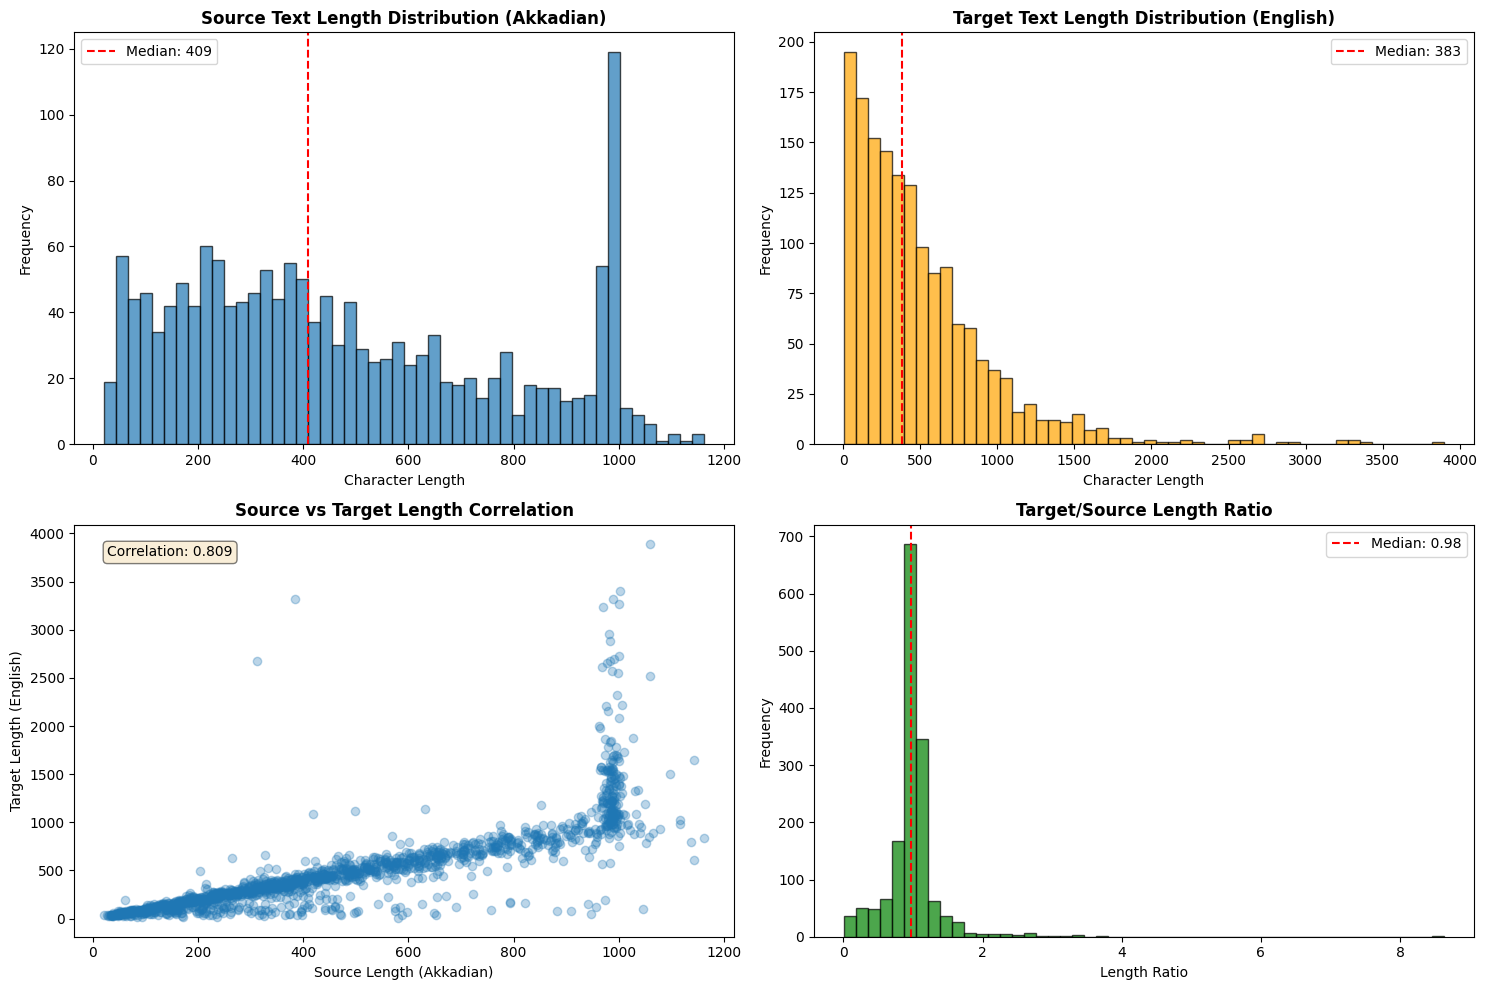

In [6]:
# Text length analysis (using cleaned data)
train_df['source_length'] = train_df['source_clean'].str.len()
train_df['target_length'] = train_df['target'].str.len()

# Basic statistics
print(f"\nDATASET OVERVIEW:")
print(f"Training documents: {len(train_df)}")
print(f"Test sentences: {len(test_df)}")
print(f"Unique test documents: {test_df['text_id'].nunique()}")
print(f"Average sentences per test document: {len(test_df) / test_df['text_id'].nunique():.1f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Source text length distribution
axes[0, 0].hist(train_df['source_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Source Text Length Distribution (Akkadian)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(train_df['source_length'].median(), color='red', 
                   linestyle='--', label=f'Median: {train_df["source_length"].median():.0f}')
axes[0, 0].legend()

# Target text length distribution
axes[0, 1].hist(train_df['target_length'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Target Text Length Distribution (English)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Character Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(train_df['target_length'].median(), color='red', 
                   linestyle='--', label=f'Median: {train_df["target_length"].median():.0f}')
axes[0, 1].legend()

# Length correlation
axes[1, 0].scatter(train_df['source_length'], train_df['target_length'], alpha=0.3)
axes[1, 0].set_title('Source vs Target Length Correlation', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Source Length (Akkadian)')
axes[1, 0].set_ylabel('Target Length (English)')
correlation = train_df['source_length'].corr(train_df['target_length'])
axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[1, 0].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Length ratio distribution
train_df['length_ratio'] = train_df['target_length'] / train_df['source_length']
axes[1, 1].hist(train_df['length_ratio'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_title('Target/Source Length Ratio', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Length Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(train_df['length_ratio'].median(), color='red', 
                   linestyle='--', label=f'Median: {train_df["length_ratio"].median():.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


In [7]:
# Statistical summary
print("\nTEXT LENGTH STATISTICS:")
print("\nSource (Akkadian):")
print(train_df['source_length'].describe())
print("\nTarget (English):")
print(train_df['target_length'].describe())

# Character analysis
print("\nCHARACTER ANALYSIS:")
all_source_chars = set(''.join(train_df['source'].astype(str)))
all_target_chars = set(''.join(train_df['target'].astype(str)))
print(f"Unique characters in Akkadian: {len(all_source_chars)}")
print(f"Unique characters in English: {len(all_target_chars)}")
print(f"\nSample Akkadian characters: {sorted(list(all_source_chars))[:50]}")

# Analyze test data structure
print("\nTEST DATA STRUCTURE:")
print(f"Total sentences: {len(test_df)}")
print(f"Unique documents (text_id): {test_df['text_id'].nunique()}")
sentences_per_doc = test_df.groupby('text_id').size()
print(f"Min sentences per document: {sentences_per_doc.min()}")
print(f"Max sentences per document: {sentences_per_doc.max()}")
print(f"Mean sentences per document: {sentences_per_doc.mean():.1f}")


TEXT LENGTH STATISTICS:

Source (Akkadian):
count    1561.000000
mean      476.365791
std       302.269667
min        22.000000
25%       227.000000
50%       409.000000
75%       706.000000
max      1162.000000
Name: source_length, dtype: float64

Target (English):
count    1561.000000
mean      499.723895
std       466.365112
min         6.000000
25%       172.000000
50%       383.000000
75%       681.000000
max      3895.000000
Name: target_length, dtype: float64

CHARACTER ANALYSIS:
Unique characters in Akkadian: 90
Unique characters in English: 110

Sample Akkadian characters: [' ', '(', ')', '+', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'D', 'E', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'W', 'Z', '[', ']', 'a', 'b', 'd', 'e', 'g', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's']

TEST DATA STRUCTURE:
Total sentences: 4
Unique documents (text_id): 1
Min sentences per document: 4
Max sentences per document: 4
Mean sentences per document:

## UNDERSTANDING THE EVALUATION METRIC
SCORING: Geometric Mean of BLEU and chrF++

The competition uses a combined metric that balances two complementary measures:

1. **BLEU (Bilingual Evaluation Understudy)**
   - Measures n-gram overlap between prediction and reference
   - Focuses on the precision of word/phrase matches
   - Range: 0-100 (higher is better)
   - Good for: Evaluating word choice and phrasing accuracy

2. **chrF++ (Character n-gram F-score)**
   - Measures character-level similarity
   - More robust to morphological variations
   - Range: 0-100 (higher is better)
   - Good for: Handling spelling variations and partial matches

Final Score = sqrt(BLEU × chrF++)

Both must be reasonably good to achieve a high final score.

In [8]:
def calculate_score(predictions, references):
    """Calculate the competition metric"""
    bleu = BLEU()
    chrf = CHRF(word_order=2)  # chrF++ uses word order
    
    bleu_score = bleu.corpus_score(predictions, [references]).score
    chrf_score = chrf.corpus_score(predictions, [references]).score
    
    # Geometric mean
    final_score = np.sqrt(bleu_score * chrf_score)
    
    return {
        'bleu': bleu_score,
        'chrf': chrf_score,
        'final_score': final_score
    }

# Example
sample_pred = ["Send the silver to Kanesh"]
sample_ref = ["Send silver to Kanesh"]
scores = calculate_score(sample_pred, sample_ref)
print(f"\nExample Scores:")
print(f"BLEU: {scores['bleu']:.2f}")
print(f"chrF++: {scores['chrf']:.2f}")
print(f"Final Score: {scores['final_score']:.2f}")



Example Scores:
BLEU: 42.73
chrF++: 80.19
Final Score: 58.54


## BASELINE 1 - MarianMT Baseline

MarianMT is a fast and efficient translation framework that supports over 50 languages.
While it wasn't trained on Akkadian, we can use it as a quick baseline.

Pros:
- Fast inference
- Small model size
- Easy to use

Cons:
- Not trained on ancient languages
- Limited performance expected
- No domain adaptation

In [9]:
class MarianTranslator:
    def __init__(self, model_name="Helsinki-NLP/opus-mt-mul-en"):
        print(f"Loading {model_name}...")
        self.tokenizer = MarianTokenizer.from_pretrained(model_name)
        self.model = MarianMTModel.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
        
    def translate(self, texts, batch_size=8, max_length=512):
        """Translate a list of texts"""
        translations = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc="Translating"):
            batch = texts[i:i+batch_size]
            
            # Tokenize
            inputs = self.tokenizer(
                batch, 
                return_tensors="pt", 
                padding=True, 
                truncation=True,
                max_length=max_length
            ).to(self.device)
            
            # Generate
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_length=max_length,
                    num_beams=4,
                    early_stopping=True
                )
            
            # Decode
            batch_translations = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)
            translations.extend(batch_translations)
        
        return translations

# Evaluate on a small validation set (using cleaned data)
val_size = min(100, len(train_df))
val_df = train_df.sample(n=val_size, random_state=42)

print(f"\nEvaluating on {val_size} samples...")
translator = MarianTranslator()
predictions = translator.translate(val_df['source_clean'].tolist())

val_scores = calculate_score(predictions, val_df['target'].tolist())
print(f"\nMarianMT Validation Scores:")
print(f"BLEU: {val_scores['bleu']:.2f}")
print(f"chrF++: {val_scores['chrf']:.2f}")
print(f"Final Score: {val_scores['final_score']:.2f}")

# Show some example translations
print("\nSample Translations:")
for i in range(min(3, len(predictions))):
    print(f"\n--- Example {i+1} ---")
    print(f"Source: {val_df.iloc[i]['source_clean'][:80]}...")
    print(f"Predicted: {predictions[i][:80]}...")
    print(f"Reference: {val_df.iloc[i]['target'][:80]}...")


Evaluating on 100 samples...
Loading Helsinki-NLP/opus-mt-mul-en...


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/707k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/791k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/310M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translating:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/310M [00:00<?, ?B/s]


MarianMT Validation Scores:
BLEU: 0.00
chrF++: 2.71
Final Score: 0.04

Sample Translations:

--- Example 1 ---
Source: 10 ma-na KÙ BABBAR s,a-ru-pu-um ni-is-ha-su2 DIRI sza-du-a-su2 sza-bu sza ta2m-k...
Predicted: 10 with BABBAR s,a-ru-pu-um ni-is-ha-su-su2 DRI-sa-du-a-su-sa-sa-sa-a-sa-a-sa-sa...
Reference: 10 minas of refined silver, its excise added, his transport fee paid, belonging ...

--- Example 2 ---
Source: 2-szi2-ta na-a2sz-pe2-ra-tum la2 pa2-ti2-a-tum sza a-ta-ta DUMU ma-num-ba-lum-a-...
Predicted: A-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-sa-...
Reference: 2 (unopened) letters of Atata, son of Mannum-balum-Assur, addressed to me and to...

--- Example 3 ---
Source: KISZIB en-na-nim DUMU a-la2-bi4-im KISZIB a-gi-a DUMU PUZUR4-a-szu3r (d)IM GAL D...
Predicted: DUCTION A-la2-bi4-IM DUU DUU PUZUR4-a-szu3r (d)IM GAL DUMU...
Reference: Sealed by Ennānum son of Ali-abum, by Agiya son of Puzur-Aššur; Adad-rabi son of...


## BASELINE 2 - Simple Dictionary Lookup (Sanity Check)

Since MarianMT fails on Akkadian (BLEU ~0), let's create a simple dictionary-based
baseline as a sanity check. This won't be good, but it's better than random!

Approach:
1. Build a simple word→word mapping from training data
2. Translate by looking up each word
3. This gives us a floor (minimum viable baseline)

In [10]:
from collections import defaultdict, Counter

class SimpleDictionaryTranslator:
    def __init__(self):
        self.word_dict = defaultdict(Counter)
        
    def train(self, source_texts, target_texts):
        """Build simple word-to-word dictionary from parallel data"""
        print("Building dictionary from training data...")
        
        for src, tgt in zip(source_texts, target_texts):
            if pd.isna(src) or pd.isna(tgt):
                continue
                
            src_words = str(src).split()
            tgt_words = str(tgt).split()
            
            # Simple heuristic: assume roughly aligned
            # In production, use proper word alignment (e.g., fast_align)
            for src_word in src_words:
                # Count all target words as possible translations
                for tgt_word in tgt_words:
                    self.word_dict[src_word][tgt_word] += 1
        
        print(f"Dictionary size: {len(self.word_dict)} source words")
        
    def translate_word(self, word):
        """Translate a single word using most common translation"""
        if word in self.word_dict:
            # Return most common translation
            return self.word_dict[word].most_common(1)[0][0]
        else:
            # Unknown word - keep as is
            return word
    
    def translate(self, texts):
        """Translate a list of texts"""
        translations = []
        for text in texts:
            if pd.isna(text):
                translations.append("")
                continue
            
            words = str(text).split()
            translated_words = [self.translate_word(w) for w in words]
            translations.append(' '.join(translated_words))
        
        return translations

# Train dictionary translator
dict_translator = SimpleDictionaryTranslator()
dict_translator.train(train_df['source_clean'], train_df['target'])

# Evaluate on validation set
val_size = min(100, len(train_df))
val_df = train_df.sample(n=val_size, random_state=42)

print(f"\nEvaluating on {val_size} samples...")
dict_predictions = dict_translator.translate(val_df['source_clean'].tolist())

dict_scores = calculate_score(dict_predictions, val_df['target'].tolist())
print(f"\nDictionary Baseline Scores:")
print(f"BLEU: {dict_scores['bleu']:.2f}")
print(f"chrF++: {dict_scores['chrf']:.2f}")
print(f"Final Score: {dict_scores['final_score']:.2f}")

# Show examples
print("\nSample Translations:")
for i in range(min(3, len(dict_predictions))):
    print(f"\n--- Example {i+1} ---")
    print(f"Source:    {val_df.iloc[i]['source_clean'][:70]}...")
    print(f"Predicted: {dict_predictions[i][:70]}...")
    print(f"Reference: {val_df.iloc[i]['target'][:70]}...")

Building dictionary from training data...
Dictionary size: 11555 source words

Evaluating on 100 samples...

Dictionary Baseline Scores:
BLEU: 3.39
chrF++: 8.04
Final Score: 5.22

Sample Translations:

--- Example 1 ---
Source:    10 ma-na KÙ BABBAR s,a-ru-pu-um ni-is-ha-su2 DIRI sza-du-a-su2 sza-bu ...
Predicted: of of of of of of of of of of the of of the of the of the of of of of ...
Reference: 10 minas of refined silver, its excise added, his transport fee paid, ...

--- Example 2 ---
Source:    2-szi2-ta na-a2sz-pe2-ra-tum la2 pa2-ti2-a-tum sza a-ta-ta DUMU ma-num...
Predicted: of of the of of of of of of of of of of of of of of of the of of of of...
Reference: 2 (unopened) letters of Atata, son of Mannum-balum-Assur, addressed to...

--- Example 3 ---
Source:    KISZIB en-na-nim DUMU a-la2-bi4-im KISZIB a-gi-a DUMU PUZUR4-a-szu3r (...
Predicted: of of of of of of of of of the of of of of of of the the of the of of ...
Reference: Sealed by Ennānum son of Ali-abum, by Agiya son of 

## BASELINE 3 - ByT5 (Character-Level Model)

ByT5 is a byte-level T5 model that works directly on characters/bytes rather 
than subwords. This makes it particularly well-suited for:
- Ancient languages with different scripts
- Morphologically rich languages
- Low-resource scenarios
- Handling rare/unknown words

Research shows ByT5 excels on ancient text translation tasks, achieving better
performance than subword models when data is limited.

Key advantages for this competition:
1. No vocabulary issues with Akkadian characters
2. Better handling of rare words
3. More robust to spelling variations
4. Character-level attention beneficial for cuneiform

Note: The code below demonstrates the ByT5 inference pipeline; actual fine-tuning should be done on the full Akkadian dataset for good performance.

In [11]:
class ByT5Translator:
    def __init__(self, model_name="google/byt5-small"):
        print(f"Loading {model_name}...")
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
    
    def prepare_input(self, text):
        """Prepare input with task prefix"""
        return f"translate Akkadian to English: {text}"
    
    def translate(self, texts, batch_size=4, max_length=512):
        """Translate a list of texts"""
        translations = []
        prepared_texts = [self.prepare_input(t) for t in texts]
        
        for i in tqdm(range(0, len(prepared_texts), batch_size), desc="Translating"):
            batch = prepared_texts[i:i+batch_size]
            
            inputs = self.tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            ).to(self.device)
            
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_length=max_length,
                    num_beams=4,
                    early_stopping=True
                )
            
            batch_translations = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)
            translations.extend(batch_translations)
        
        return translations

## RECOMMENDED APPROACHES & NEXT STEPS

**CRITICAL: Address Document vs Sentence Mismatch**
The training data has ~1,500 document-level translations, but the test data has
~4,000 sentence-level translations. Consider:
- Use Sentences_Oare_FirstWord_LinNum.csv to split training documents into sentences
- Sentence-level training will better match the test format

1. **Fine-tune ByT5/mT5**
   - Fine-tune on sentence-level aligned data (after splitting documents)
   - Use learning rate ~3e-4, batch size 8-16
   - Train for 5-10 epochs with early stopping

2. **Fine-tune mBART**
   - Model: facebook/mbart-large-50-many-to-many-mmt
   - Excellent for low-resource translation
   - Add language tokens for Akkadian

3. **Leverage Supplemental Data** (HIGH IMPACT)
   - **published_texts.csv**: ~8,000 additional Akkadian transliterations
   - **publications.csv**: ~880 PDFs with translations (multiple languages)
   - **OA_Lexicon_eBL.csv**: Akkadian-English dictionary (great for vocabulary)
   
   Advanced approach:
   a. Extract translations from publications.csv using OCR + LLM
   b. Align with published_texts.csv using document IDs
   c. Convert non-English translations to English
   d. Split into sentence-level pairs
   e. This could give you 5,000-10,000+ additional training examples!

4. **Data Augmentation**
   - Add noise to increase robustness
   - Use the dictionary for vocabulary expansion
   - Paraphrase English translations

5. **Ensemble Methods**
   - Combine ByT5 + mBART + MarianMT predictions
   - Weighted averaging based on validation performance

6. **Advanced Techniques**
   - Custom tokenizers using OA_Lexicon_eBL.csv
   - Multi-task learning (translation + NER + POS)
   - Attention visualization for interpretability
   - Domain adaptation from other ancient languages
   - Use dictionary embeddings to initialize model

7. **Prompt Engineering (for LLMs)** EMERGING APPROACH
   - Few-shot prompting with GPT-4/Claude with examples from training data
   - Include dictionary definitions from eBL_Dictionary.csv
   - Include genre/context information (these are business records)
   - Chain-of-thought for complex sentences

**Quick Win Ideas:**
1. Split training documents → sentence-level (use Sentences_Oare_FirstWord_LinNum.csv)
2. Fine-tune ByT5-small on sentences
3. Ensemble 2-3 models

## CREATING A SUBMISSION

In [12]:
# Generate predictions for test set (using cleaned data)
print("Generating test predictions...")
test_predictions = translator.translate(test_df['source_clean'].tolist())

# Create submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("\n✅ Submission saved to submission.csv")
print(f"Submission shape: {submission.shape}")
print("\nFirst few predictions:")
print(submission.head())

Generating test predictions...


Translating:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Submission saved to submission.csv
Submission shape: (4, 2)

First few predictions:
   id                                             target
0   0  The ka3-rum ka3-i-i-i-i-i-i-i-i-i-i-i-i-i-i-i-...
1   1  I-I-I-I-I-I-I-I-I-I-I-I-I-I-I-I-I-I-I-I-I-I-I-...
2   2  I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'...
3   3  Me-+e-er mup-pi3 in ka3-ar-and-a-wa-bar-ra-tim...


## RESOURCES AND REFERENCES
**Competition Resources:**
- Competition Page: https://www.kaggle.com/competitions/deep-past-initiative-machine-translation
- Deep Past Initiative: https://www.deeppast.org/

**Akkadian Resources:**
- ORACC (Open Richly Annotated Cuneiform Corpus): http://oracc.org/
- Cuneiform Digital Library Initiative (CDLI): https://cdli.ucla.edu/

**Model Hubs:**
- Hugging Face Transformers: https://huggingface.co/models
- Pre-trained models: mBART, ByT5, MarianMT, mT5

**Papers:**
1. Gutherz et al. (2023) - "Translating Akkadian to English with neural machine translation"
2. Xue et al. (2022) - "ByT5: Towards a token-free future"
3. Liu et al. (2020) - "Multilingual Denoising Pre-training for NMT"
4. Anderson et al. (2023) - "Machine Learning for Ancient Languages: A Survey"


**Tips:**
- Start simple, iterate quickly
- Monitor both BLEU and chrF++ during training
- Use validation set to prevent overfitting
- Ensemble different approaches